In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = '/content/drive/My Drive/capstone/rb/'

df = pd.DataFrame(columns = ['Index', 'Part', 'size', 'size_percent', 'whole_sat_level', 'red_percent', 'red_sat_level', 
                             'blue_percent', 'blue_sat_level', 'purple_percent', 'orange_percent', 'dark_percent']) 

for folder in os.listdir(base_dir):
  for f in os.listdir(os.path.join(base_dir, folder)):
    file_name = os.path.join(os.path.join(base_dir, folder), f)
    idx =  folder
    if 'mask' in f:
      mask_idx = f.index('mask')
    else:
      continue
    i_idx = f.index(idx)
    part = f[(mask_idx + 5):(i_idx-1)]

    img = cv2.imread(file_name)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) # Not good. Not used for dark percent.
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    ret, thresh = cv2.threshold(img_gray, 50, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
      df = df.append({'Index':idx, 'Part':part, 'size':0, 'whole_sat_level':None, 'red_percent':None, 'red_sat_level':None,
                    'blue_percent':None, 'blue_sat_level':None, 'purple_percent':None, 'orange_percent':None, 
                    'dark_percent':None},  ignore_index = True)
      continue

    l = []
    for i in range(len(contours)):
      l.append(len(contours[i]))
    cnt_idx = l.index(max(l)) 

    mask = np.zeros_like(img_gray)
    cv2.drawContours(mask, contours, cnt_idx, 255, -1);
    area = cv2.contourArea(contours[cnt_idx])
    size_pixel = area

    hue = cv2.calcHist( [img_hsv], [0], img_gray, [180], [0, 180] )
    sat = cv2.calcHist( [img_hsv], [1], img_gray, [256], [0, 256] )
    val = cv2.calcHist( [img_hsv], [2], img_gray, [256], [0, 256] )

    # lightness = cv2.calcHist( [img_lab], [0], mask, [100], [0, 100] ) # Not used

    #if ('anal' in file_name) or ('dorsal_fin' in file_name) or ('pelvic' in file_name) or ('tail' in file_name) or ('body' in file_name) or ('head' in file_name):
    very_low_sat_pixel = sum(sat[0:25])
    low_sat_pixel = sum(sat[15:70])
    high_sat_pixel = sum(sat[50:200])
    total_pixel = sum(hue)
    very_low_sat_percent = very_low_sat_pixel/total_pixel
    low_sat_percent = low_sat_pixel/total_pixel
    high_sat_percent = high_sat_pixel/total_pixel

    if very_low_sat_percent > 0.65:
      sat_level = 'very_low'
    elif low_sat_percent > 0.6:
      sat_level = 'low'
    elif high_sat_percent > 0.6:
      sat_level = 'high'
    elif low_sat_percent > 0.45 and high_sat_percent > 0.45:
      sat_level = 'low'
    else:
      sat_level = 'else'

    red_pixel = int(sum(hue[0:12]) + sum(hue[160:179]))
    red_percent = float(red_pixel / total_pixel)
    orange_pixel = int(sum(hue[13:25]))
    orange_percent = float(orange_pixel / total_pixel)
    blue_pixel = int(sum(hue[100:135]))
    blue_percent = float(blue_pixel / total_pixel)
    purple_pixel = int(sum(hue[136:160]))
    purple_percent = float(purple_pixel / total_pixel)
    dark_pixel = int(sum(val[0:80]))
    dark_percent = float(dark_pixel / total_pixel)

    mask_red = np.zeros_like(img_gray)
    mask_blue = np.zeros_like(img_gray)
    for (i, j) in zip(*np.where(np.logical_or(np.logical_and(img_hsv[:,:,0] < 12, img_hsv[:,:,0] > 0), np.logical_and(img_hsv[:,:,0] < 180, img_hsv[:,:,0] > 160)))):
      mask_red[i, j] = 255
    sat_red = cv2.calcHist( [img_hsv], [1], mask_red, [256], [0, 256] )
    for (i, j) in zip(*np.where(np.logical_and(img_hsv[:,:,0] < 135, img_hsv[:,:,0] > 100))):
      mask_blue[i, j] = 255
    sat_blue = cv2.calcHist( [img_hsv], [1], mask_blue, [256], [0, 256] )

    very_low_sat_pixel_red = sum(sat_red[0:25])
    low_sat_pixel_red = sum(sat_red[15:70])
    high_sat_pixel_red = sum(sat_red[50:200])
    total_pixel_red = sum(sat_red)
    if total_pixel_red != 0:
      very_low_sat_percent_red = very_low_sat_pixel_red/total_pixel_red
      low_sat_percent_red = low_sat_pixel_red/total_pixel_red
      high_sat_percent_red = high_sat_pixel_red/total_pixel_red
    else:
      very_low_sat_percent_red = 0
      low_sat_percent_red = 0
      high_sat_percent_red = 0

    if very_low_sat_percent_red > 0.65:
      sat_level_red = 'very_low'
    elif low_sat_percent_red > 0.6:
      sat_level_red = 'low'
    elif high_sat_percent_red > 0.6:
      sat_level_red = 'high'
    elif low_sat_percent_red > 0.45 and high_sat_percent_red > 0.45:
      sat_level_red = 'low'
    else:
      sat_level_red = 'else'

    very_low_sat_pixel_blue = sum(sat_blue[0:25])
    low_sat_pixel_blue = sum(sat_blue[15:70])
    high_sat_pixel_blue = sum(sat_blue[50:200])
    total_pixel_blue = sum(sat_blue)
    if total_pixel_blue != 0:
      very_low_sat_percent_blue = very_low_sat_pixel_blue/total_pixel_blue
      low_sat_percent_blue = low_sat_pixel_red/total_pixel_blue
      high_sat_percent_blue = high_sat_pixel_blue/total_pixel_blue
    else:
      very_low_sat_percent_blue = 0
      low_sat_percent_blue = 0
      high_sat_percent_blue = 0

    if very_low_sat_percent_blue > 0.65:
      sat_level_blue = 'very_low'
    elif low_sat_percent_blue > 0.6:
      sat_level_blue = 'low'
    elif high_sat_percent_blue > 0.6:
      sat_level_blue = 'high'
    elif low_sat_percent_blue > 0.45 and high_sat_percent_blue > 0.45:
      sat_level_blue = 'low'
    else:
      sat_level_blue = 'else'

    df = df.append({'Index':idx, 'Part':part, 'size':size_pixel, 'whole_sat_level':sat_level, 'red_percent':red_percent, 'red_sat_level':sat_level_red,
                    'blue_percent':blue_percent, 'blue_sat_level':sat_level_blue, 'purple_percent':purple_percent, 'orange_percent':orange_percent, 
                    'dark_percent':dark_percent},  ignore_index = True)

df_2 = df.groupby(['Index']).sum()
df = df.join(df_2.iloc[:, 0:1], how = 'left', rsuffix='_whole', on = 'Index')
df.size_percent = df['size']/df['size_whole']
df = df.drop(['size', 'size_whole'], axis =1)

In [ ]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)
df

,Index,Part,size_percent,whole_sat_level,red_percent,red_sat_level,blue_percent,blue_sat_level,purple_percent,orange_percent,dark_percent
0,149,body,0.247564,high,0.014360,low,0.532154,high,0.005681,0.038191,0.662371
1,149,dorsal_fin,0.223330,high,0.008278,low,0.798865,high,0.000645,0.004823,0.006377
2,149,anal_fin,0.008493,low,0.123951,low,0.447130,high,0.046788,0.090298,0.367084
3,149,pelvic_fin,0.034287,low,0.022757,low,0.022988,else,0.003511,0.131843,0.529483
4,149,head,0.038726,low,0.006487,very_low,0.018069,high,0.000890,0.026937,0.864057
...,...,...,...,...,...,...,...,...,...,...,...
505,150,head,0.092358,high,0.095792,high,0.015681,low,0.002121,0.202443,0.442001
506,150,body,0.346126,high,0.061871,low,0.421715,high,0.017837,0.194854,0.476735
507,150,dorsal_fin,0.069633,high,0.119692,high,0.761696,high,0.076944,0.005680,0.021441
508,150,pelvic_fin,0.004500,high,0.845182,high,0.021303,low,0.008174,0.050780,0.000000


In [ ]:
df_body = df.loc[df.Part == 'body']
df_body = df_body.drop(['Part'], axis=1)

df_tail = df.loc[df.Part == 'tail']
df_tail = df_tail.drop(['Part'], axis=1)

df_dorsal = df.loc[df.Part == 'dorsal_fin']
df_dorsal = df_dorsal.drop(['Part'], axis=1)

df_anal = df.loc[df.Part == 'anal_fin']
df_anal = df_anal.drop(['Part'], axis=1)

df_head = df.loc[df.Part == 'head']
df_head = df_head.drop(['Part'], axis=1)

df_pelvic = df.loc[df.Part == 'pelvic_fin']
df_pelvic = df_pelvic.drop(['Part'], axis=1)

In [ ]:
df_head = df_head.sort_values(by=['Index'])
df_body = df_body.sort_values(by=['Index'])
df_tail = df_tail.sort_values(by=['Index'])
df_pelvic = df_pelvic.sort_values(by=['Index'])
df_anal = df_anal.sort_values(by=['Index'])
df_dorsal = df_dorsal.sort_values(by=['Index'])

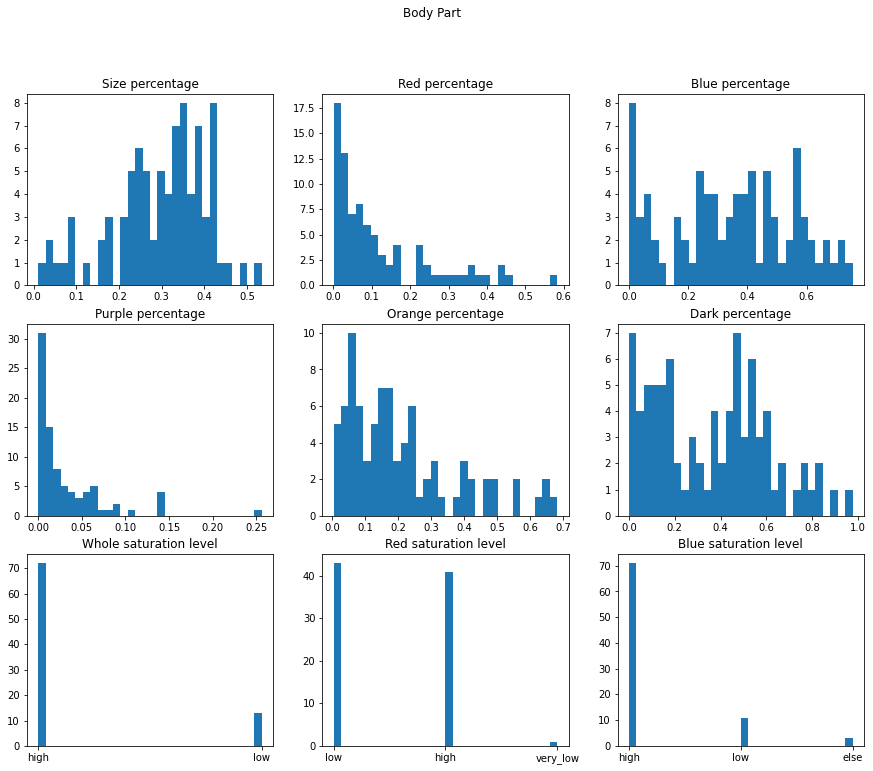

In [ ]:
fig, axs = plt.subplots(3, 3, figsize = (15, 12))
fig.suptitle('Body Part')

axs[0][0].hist(df_body.size_percent, bins = 30);
axs[0][0].set_title("Size percentage");

axs[0][1].hist(df_body.red_percent, bins = 30);
axs[0][1].set_title("Red percentage");

axs[0][2].hist(df_body.blue_percent, bins = 30);
axs[0][2].set_title("Blue percentage");

axs[1][0].hist(df_body.purple_percent, bins = 30);
axs[1][0].set_title("Purple percentage");

axs[1][1].hist(df_body.orange_percent, bins = 30);
axs[1][1].set_title("Orange percentage");

axs[1][2].hist(df_body.dark_percent, bins = 30);
axs[1][2].set_title("Dark percentage");

axs[2][0].hist(df_body.whole_sat_level, bins = 30);
axs[2][0].set_title("Whole saturation level");

axs[2][1].hist(df_body.red_sat_level, bins = 30);
axs[2][1].set_title("Red saturation level");

axs[2][2].hist(df_body.blue_sat_level, bins = 30);
axs[2][2].set_title("Blue saturation level");

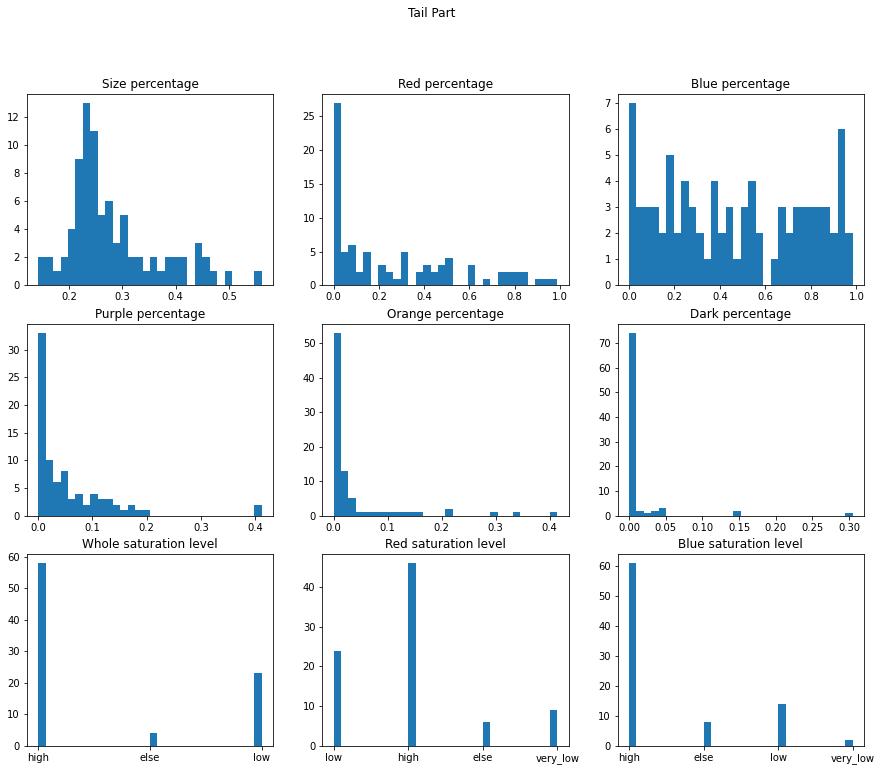

In [ ]:
fig, axs = plt.subplots(3, 3, figsize = (15, 12))
fig.suptitle('Tail Part')

axs[0][0].hist(df_tail.size_percent, bins = 30);
axs[0][0].set_title("Size percentage");

axs[0][1].hist(df_tail.red_percent, bins = 30);
axs[0][1].set_title("Red percentage");

axs[0][2].hist(df_tail.blue_percent, bins = 30);
axs[0][2].set_title("Blue percentage");

axs[1][0].hist(df_tail.purple_percent, bins = 30);
axs[1][0].set_title("Purple percentage");

axs[1][1].hist(df_tail.orange_percent, bins = 30);
axs[1][1].set_title("Orange percentage");

axs[1][2].hist(df_tail.dark_percent, bins = 30);
axs[1][2].set_title("Dark percentage");

axs[2][0].hist(df_tail.whole_sat_level, bins = 30);
axs[2][0].set_title("Whole saturation level");

axs[2][1].hist(df_tail.red_sat_level, bins = 30);
axs[2][1].set_title("Red saturation level");

axs[2][2].hist(df_tail.blue_sat_level, bins = 30);
axs[2][2].set_title("Blue saturation level");

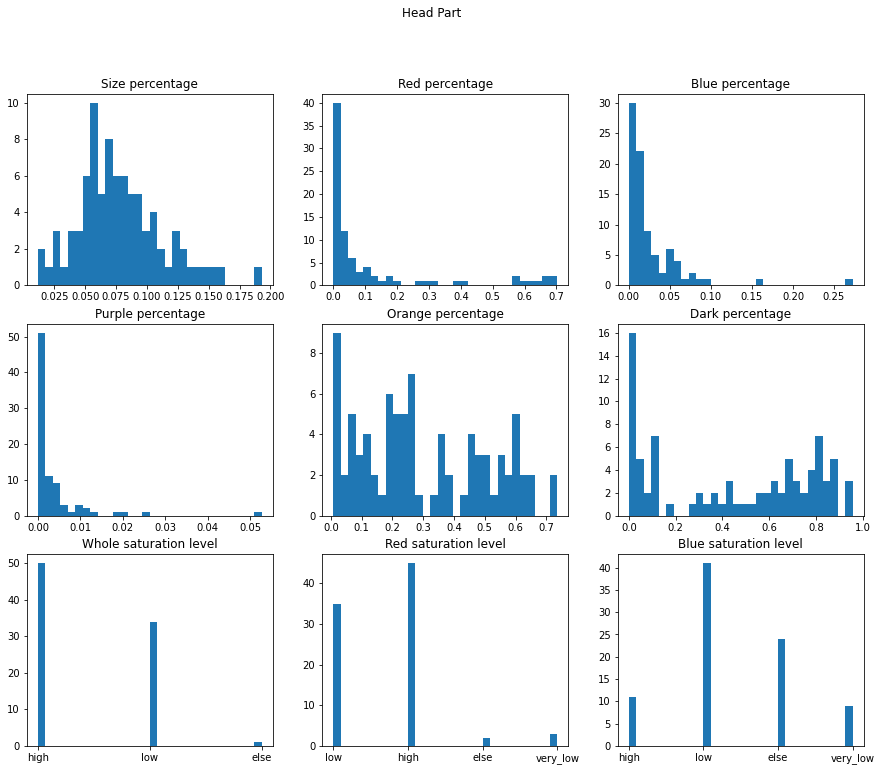

In [ ]:
fig, axs = plt.subplots(3, 3, figsize = (15, 12))
fig.suptitle('Head Part')

axs[0][0].hist(df_head.size_percent, bins = 30);
axs[0][0].set_title("Size percentage");

axs[0][1].hist(df_head.red_percent, bins = 30);
axs[0][1].set_title("Red percentage");

axs[0][2].hist(df_head.blue_percent, bins = 30);
axs[0][2].set_title("Blue percentage");

axs[1][0].hist(df_head.purple_percent, bins = 30);
axs[1][0].set_title("Purple percentage");

axs[1][1].hist(df_head.orange_percent, bins = 30);
axs[1][1].set_title("Orange percentage");

axs[1][2].hist(df_head.dark_percent, bins = 30);
axs[1][2].set_title("Dark percentage");

axs[2][0].hist(df_head.whole_sat_level, bins = 30);
axs[2][0].set_title("Whole saturation level");

axs[2][1].hist(df_head.red_sat_level, bins = 30);
axs[2][1].set_title("Red saturation level");

axs[2][2].hist(df_head.blue_sat_level, bins = 30);
axs[2][2].set_title("Blue saturation level");

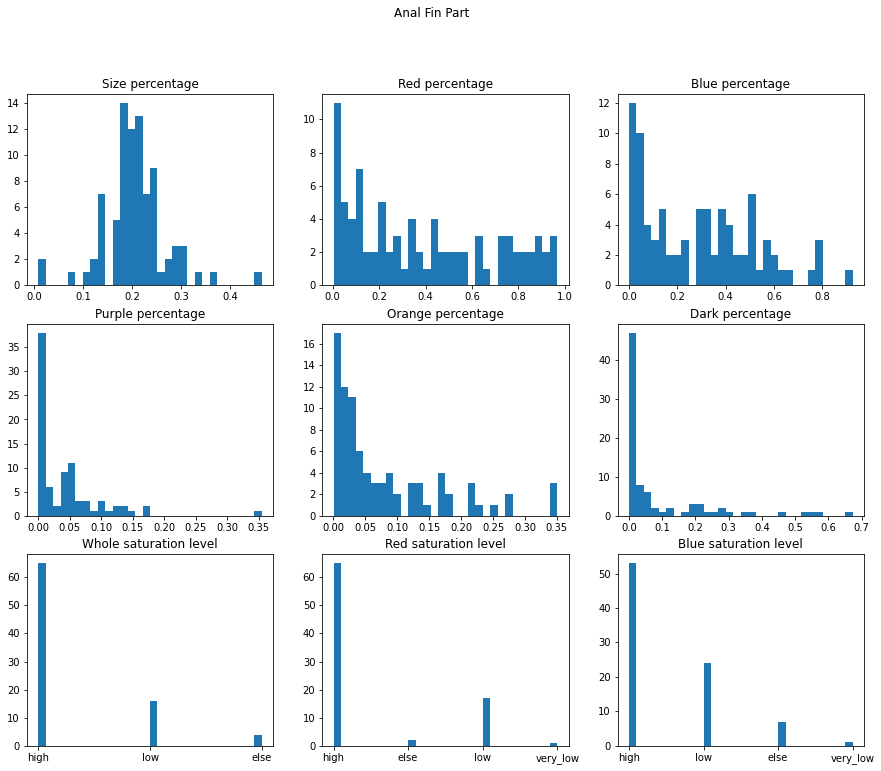

In [ ]:
fig, axs = plt.subplots(3, 3, figsize = (15, 12))
fig.suptitle('Anal Fin Part')

axs[0][0].hist(df_anal.size_percent, bins = 30);
axs[0][0].set_title("Size percentage");

axs[0][1].hist(df_anal.red_percent, bins = 30);
axs[0][1].set_title("Red percentage");

axs[0][2].hist(df_anal.blue_percent, bins = 30);
axs[0][2].set_title("Blue percentage");

axs[1][0].hist(df_anal.purple_percent, bins = 30);
axs[1][0].set_title("Purple percentage");

axs[1][1].hist(df_anal.orange_percent, bins = 30);
axs[1][1].set_title("Orange percentage");

axs[1][2].hist(df_anal.dark_percent, bins = 30);
axs[1][2].set_title("Dark percentage");

axs[2][0].hist(df_anal.whole_sat_level, bins = 30);
axs[2][0].set_title("Whole saturation level");

axs[2][1].hist(df_anal.red_sat_level, bins = 30);
axs[2][1].set_title("Red saturation level");

axs[2][2].hist(df_anal.blue_sat_level, bins = 30);
axs[2][2].set_title("Blue saturation level");

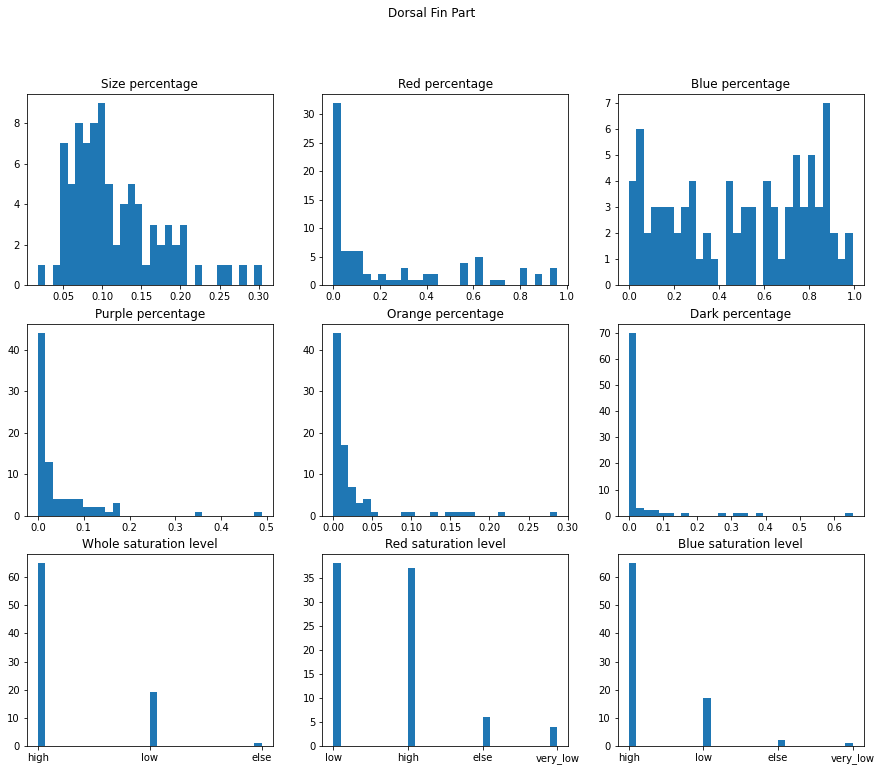

In [ ]:
fig, axs = plt.subplots(3, 3, figsize = (15, 12))
fig.suptitle('Dorsal Fin Part')

axs[0][0].hist(df_dorsal.size_percent, bins = 30);
axs[0][0].set_title("Size percentage");

axs[0][1].hist(df_dorsal.red_percent, bins = 30);
axs[0][1].set_title("Red percentage");

axs[0][2].hist(df_dorsal.blue_percent, bins = 30);
axs[0][2].set_title("Blue percentage");

axs[1][0].hist(df_dorsal.purple_percent, bins = 30);
axs[1][0].set_title("Purple percentage");

axs[1][1].hist(df_dorsal.orange_percent, bins = 30);
axs[1][1].set_title("Orange percentage");

axs[1][2].hist(df_dorsal.dark_percent, bins = 30);
axs[1][2].set_title("Dark percentage");

axs[2][0].hist(df_dorsal.whole_sat_level, bins = 30);
axs[2][0].set_title("Whole saturation level");

axs[2][1].hist(df_dorsal.red_sat_level, bins = 30);
axs[2][1].set_title("Red saturation level");

axs[2][2].hist(df_dorsal.blue_sat_level, bins = 30);
axs[2][2].set_title("Blue saturation level");

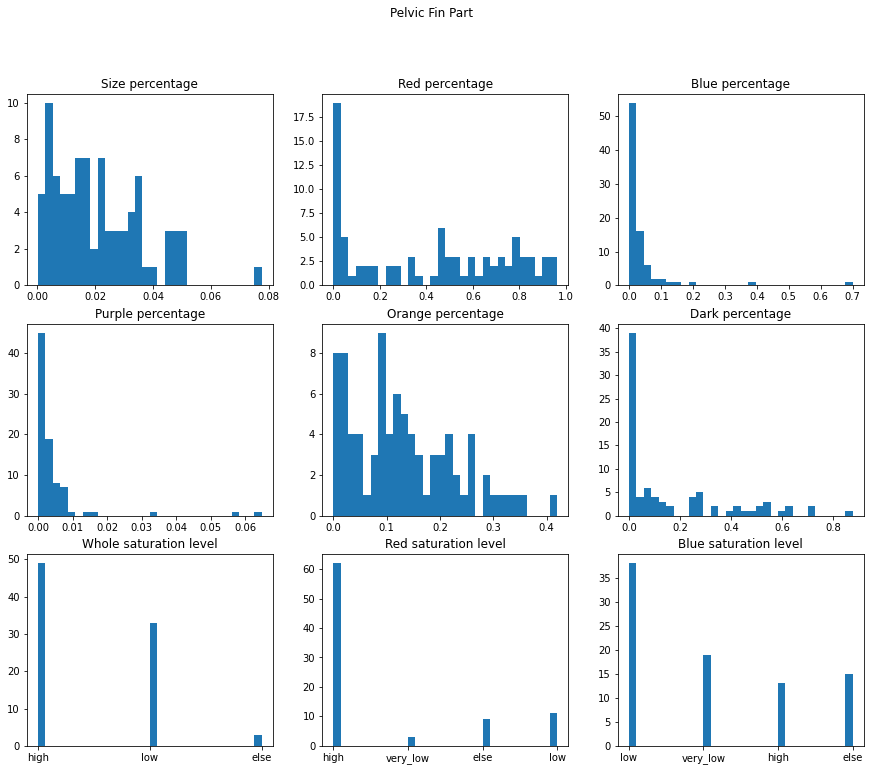

In [ ]:
fig, axs = plt.subplots(3, 3, figsize = (15, 12))
fig.suptitle('Pelvic Fin Part')

axs[0][0].hist(df_pelvic.size_percent, bins = 30);
axs[0][0].set_title("Size percentage");

axs[0][1].hist(df_pelvic.red_percent, bins = 30);
axs[0][1].set_title("Red percentage");

axs[0][2].hist(df_pelvic.blue_percent, bins = 30);
axs[0][2].set_title("Blue percentage");

axs[1][0].hist(df_pelvic.purple_percent, bins = 30);
axs[1][0].set_title("Purple percentage");

axs[1][1].hist(df_pelvic.orange_percent, bins = 30);
axs[1][1].set_title("Orange percentage");

axs[1][2].hist(df_pelvic.dark_percent, bins = 30);
axs[1][2].set_title("Dark percentage");

axs[2][0].hist(df_pelvic.whole_sat_level, bins = 30);
axs[2][0].set_title("Whole saturation level");

axs[2][1].hist(df_pelvic.red_sat_level, bins = 30);
axs[2][1].set_title("Red saturation level");

axs[2][2].hist(df_pelvic.blue_sat_level, bins = 30);
axs[2][2].set_title("Blue saturation level");

In [ ]:
geno = pd.read_csv('/content/drive/My Drive/capstone/subset_RBF2_genotype_and_map.csv')
geno = geno.astype({'id': 'str'})

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
pd.set_option("display.max_rows", 20, "display.max_columns", 30)

df_out = df_head.join(geno.set_index('id'), how = 'right', on = 'Index')
df_out = df_tail.join(df_out.set_index('Index'), how = 'right', on = 'Index', lsuffix="_tail", rsuffix='_head')
df_out = df_body.join(df_out.set_index('Index'), how = 'right', on = 'Index')
df_out = df_anal.join(df_out.set_index('Index'), how = 'right', on = 'Index', lsuffix="_anal", rsuffix="_body")
df_out = df_pelvic.join(df_out.set_index('Index'), how = 'right', on = 'Index')
df_out = df_dorsal.join(df_out.set_index('Index'), how = 'right', on = 'Index', lsuffix="_dorsal", rsuffix="_pelvic")
df_out = df_out.drop(['Index'], axis = 1)

df_out = df_out.replace('high', 3)
df_out = df_out.replace('low', 2)
df_out = df_out.replace('very_low', 1)
df_out = df_out.replace('else', 0)

In [ ]:
df_out.to_csv(r'/content/drive/My Drive/capstone/RBF2_geno_and_pheno.csv', index=False)